In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from ..FindCorrespondPts import findCorrespondPts
from ..segmentation import robotSegment, ransacCurveFit
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook
from collections import defaultdict

## Load Optimal Fundamental Matrix

In [3]:
coeff_left = np.load('../calibration/calibration_coeff_left.npy').item()
kl = coeff_left['intr_mat']

coeff_right = np.load('../calibration/calibration_coeff_right.npy').item()
kr = coeff_right['intr_mat']

trian_param = np.load('../calibration/triangulate_coeff.npy').item()

F = trian_param['F']
# 2 possible solutions for Rotation and Translation
R1 = trian_param['R1']
R2 = trian_param['R2']
T1 = trian_param['T1']
T2 = trian_param['T2']

# 4 Possible projection matrix for right camera
PR1 = np.hstack((R1, T1))
PR2 = np.hstack((R1, T2))
PR3 = np.hstack((R2, T1))
PR4 = np.hstack((R2, T2))

# Initialize Left projection matrix
PL = trian_param['PL']


PR = PR4

# Calculate template points
PR_cal = np.matmul(kr, PR)
PL_cal = np.matmul(kl, PL)



In [114]:
# Loading end point data for reconstruction
endL = np.load('./data_F/ptsL800_end.npy').item()
endR = np.load('./data_F/ptsR800_end.npy').item()

eval_idx_all = np.load('./data_F/eval_idx.npy')
eval_idx = eval_idx_all[0:50]


## Sample Num on Corresponding Points Searching

In [116]:
final_res = {}

for num in tqdm_notebook(np.logspace(2, 5, num = 50).astype('int')):
    stage_res = []
    for idx in eval_idx:
        imgL = cv2.imread('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
        imgR = cv2.imread('../../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

        bg1 = cv2.imread('../segmentation/bg_res/bg_1.png')
        bg2 = cv2.imread('../segmentation/bg_res/bg_2_' + str(idx//50) + '.png')

        segL = robotSegmentv2(imgL, bg2)
        segR = robotSegmentv2(imgR, bg1)

        pts_end_R = endR[idx][1]
        pts_end_L = endL[idx][1]

        ptsR = ransacCurveFit(segR, pt_end = pts_end_R, degree = 7, trials = 100, sampleNum = num)
        ptsL = ransacCurveFit(segL, pt_end = pts_end_L, degree = 7, trials = 100, sampleNum = 100)

        # Caculate Epipolar Constraint with Absolute Value
        pts_cor_L, pts_cor_R = findCorrespondPts(ptsL, ptsR, F, thresh = 10)
        test_left, test_right = pts_cor_L[0], pts_cor_R[0]
        test_left = np.hstack((test_left, np.ones((len(test_left),1))))
        test_right = np.hstack((test_right, np.ones((len(test_right),1))))
        F_res = np.matmul(np.matmul(test_right, F), test_left.T)
        sum_res = np.sum(np.abs(np.diag(F_res)))
        stage_res.append(sum_res)
    
    final_res[num] = sum(stage_res)
    

In [136]:
#np.save('absolute_error_sample_num.npy', final_res)
final_res = np.load('absolute_error_sample_num.npy').item()

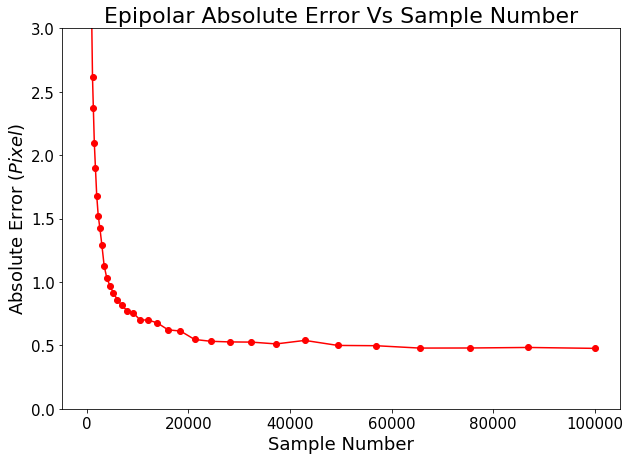

In [135]:
# In 100 cases, the accumulated sampling errors


x = list(final_res.keys())
y = []
for key in final_res.keys():
    y.append(final_res[key]*2)
    
plt.figure(figsize = (10, 7))
plt.ylim([0, 3])
#plt.xlim([0, 50000])
plt.plot(x, y, c = 'r', marker = 'o')
plt.title('Epipolar Absolute Error Vs Sample Number', fontsize = 22)
plt.ylabel('Absolute Error ($Pixel$)', fontsize=18)
plt.xlabel('Sample Number', fontsize=18)
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15) 
plt.savefig("epipolar_error_sample_number.pdf", bbox_inches='tight')
plt.show()

## Sample Num on Final Reconstruction

In [169]:
final_recon_res = defaultdict(dict)
pts3D_eval = {}

range1 = list(np.linspace(10, 100, num = 10))
range2 = list(np.linspace(150, 1000, num = 18))
test_list = range1 + range2

pt_seg_left = np.load('./data_F/ptsL800_out.npy').item()
pt_seg_right = np.load('./data_F/ptsR800_out.npy').item()

imgl_pts = np.load('../calibration/blob_loc_left.npy')
imgr_pts = np.load('../calibration/blob_loc_right.npy')

In [170]:
# Load length data
from scipy.io import loadmat
dist_gt = {}
for idx in eval_idx:
    mat = loadmat('../../data/CTR_Robot/Robot_data/pos_' + str(idx) + '.mat')['pos'][0]
    # Calculate ground truth length
    dist_inner = 431 + mat[0]*1000
    #dist_mid = 332 + mat[1]*1000
    dist_out = 174 + mat[2]*1000
    # Save results
    dist_gt[idx] = (dist_inner, dist_out)

In [171]:
def distCal(pts):
    L = 0
    Xs, Ys, Zs = pts[0], pts[1], pts[2]
    for idx in range(len(pts)-1):
        xd = (Xs[idx-1]-Xs[idx])**2
        yd = (Ys[idx-1]-Ys[idx])**2
        zd = (Zs[idx-1]-Zs[idx])**2
        L += np.sqrt(xd+yd+zd)
    return L

In [172]:
########################################### Template for rescaling ##################################################
temp = cv2.triangulatePoints(PL_cal, PR_cal, imgl_pts, imgr_pts).T
temp3D = cv2.convertPointsFromHomogeneous(temp).T[:,0]
# Recover scale from template points
Xs_tp = temp3D[0]
Ys_tp = temp3D[1]
Zs_tp = temp3D[2]

dist_dot = []
for idx in range(len(Xs_tp)-1):
    xd = (Xs_tp[idx]-Xs_tp[idx+1])**2
    yd = (Ys_tp[idx]-Ys_tp[idx+1])**2
    zd = (Zs_tp[idx]-Zs_tp[idx+1])**2
    L = np.sqrt(xd+yd+zd)
    if L < 0.1:
        dist_dot.append(L)
recon_dist = np.mean(dist_dot)


################################################ Evaluate #####################################################################
dist_eval = {}
template_dist = 18.2
scale = template_dist/recon_dist

In [173]:
for num in tqdm_notebook(test_list):
    for idx in eval_idx:
        imgL = cv2.imread('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
        imgR = cv2.imread('../../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

        bg1 = cv2.imread('../segmentation/bg_res/bg_1.png')
        bg2 = cv2.imread('../segmentation/bg_res/bg_2_' + str(idx//50) + '.png')

        segL = robotSegmentv2(imgL, bg2)
        segR = robotSegmentv2(imgR, bg1)

        pts_end_R = endR[idx][1]
        pts_end_L = endL[idx][1]

        ptsR = ransacCurveFit_v3(segR, pt_end = pts_end_R, degree = 7, trials = 100, sampleNum = 50000)
        ptsL = ransacCurveFit_v3(segL, pt_end = pts_end_L, degree = 7, trials = 100, sampleNum = num)

        ptsL_cor, ptsR_cor = findCorrespondPts_v3(ptsL, ptsR, F, thresh = 0.01)

        pts = cv2.triangulatePoints(PL_cal, PR_cal, ptsL_cor, ptsR_cor).T
        pts3D = cv2.convertPointsFromHomogeneous(pts).T[:,0]
        pts3D_eval[idx] = [ptsL_cor, ptsR_cor, pts3D]


    pt_joint_eval = {}
    for idx in tqdm_notebook(eval_idx):
        if idx in pt_seg_left:
            pt_seg = pt_seg_left
            pts_cor = pts3D_eval[idx][0]
        elif idx in pt_seg_right:
            pt_seg = pt_seg_right
            pts_cor = pts3D_eval[idx][1]

        # extract label joint points 
        pt1 = pt_seg[idx]

        # calculate most close points as joint point
        mat1 = pts_cor[0] - pt1
        dist1 = np.sqrt(np.diag(np.matmul(mat1, mat1.T)))
        jointPt1 = np.argmin(dist1)

        # save 2 joints for each case
        pt_joint_eval[idx] = jointPt1



    for idx in eval_idx:
        # Load reconstruction result
        pts3D = pts3D_eval[idx][2]
        # Load segment point idx
        seg_idx1 = pt_joint_eval[idx]
        # Outter seg
        seg1 = pts3D.T[0:seg_idx1]
        # Inner seg
        seg3 = pts3D.T

        dist_out = distCal(seg1.T)*scale
        dist_inner = distCal(seg3.T)*scale

        dist_eval[idx] = (dist_inner, dist_out) 

    # Caculate Error
    error = {}
    for idx in eval_idx:
        gt_in, gt_out = dist_gt[idx]
        cal_in, cal_out = dist_eval[idx]
        error[idx] = (gt_in-cal_in, gt_out-cal_out)


    out_cal = []
    inner_cal = []

    out_gt = []
    inner_gt = []

    out_error = []
    inner_error = []

    index = []

    for key in dist_eval.keys():
        index.append(key)

        out_cal.append(dist_eval[key][1])
        inner_cal.append(dist_eval[key][0])

        out_gt.append(dist_gt[key][1])
        inner_gt.append(dist_gt[key][0])

        out_error.append(error[key][1])
        inner_error.append(error[key][0])

    data = {
        'index': index,   
        'inner_cal': inner_cal,
        'out_cal': out_cal,  
        'inner_gt':inner_gt,  
        'out_gt': out_gt,
        'inner_error':inner_error,  
        'out_error':out_error,
    }

    ############################################### Statistic #################################################
    res_data = pd.DataFrame(data)
    in_cor = np.corrcoef(res_data['inner_cal'], res_data['inner_gt'])

    in_mean = np.mean(np.abs(res_data['inner_error']))
    in_std = np.std(np.abs(res_data['inner_error']))

    out_cor = np.corrcoef(res_data['out_cal'], res_data['out_gt'])
    out_mean = np.mean(np.abs(res_data['out_error']))
    out_std = np.std(np.abs(res_data['out_error']))

    final_recon_res[num]['inner_error_mean'] = in_mean
    final_recon_res[num]['inner_error_dev'] = in_std
    final_recon_res[num]['outter_error_mean'] = out_mean
    final_recon_res[num]['outter_error_dev'] = out_std

In [2]:
#np.save('length_error_sample_num.npy', final_recon_res)
final_recon_res = np.load('length_error_sample_num.npy').item()

In [3]:
x = list(final_recon_res.keys())

y_out_mean = []
y_out_std = []

y_in_mean = []
y_in_std = []

for key in final_recon_res.keys():
    y_out_mean.append(final_recon_res[key]['outter_error_mean'])
    y_out_std.append(final_recon_res[key]['outter_error_dev'])
    y_in_mean.append(final_recon_res[key]['inner_error_mean'])
    y_in_std.append(final_recon_res[key]['inner_error_dev'])    

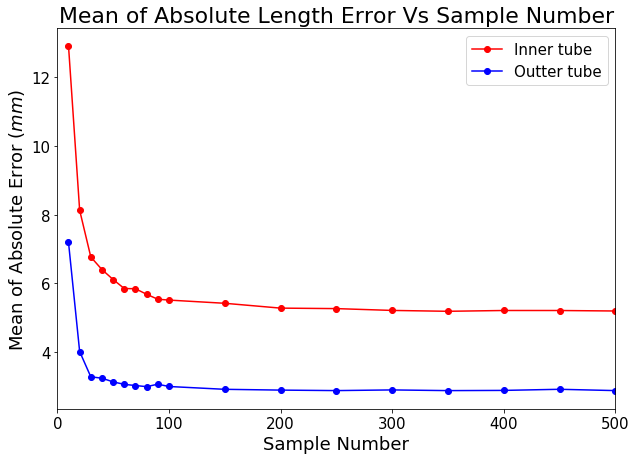

In [217]:
plt.figure(figsize = (10, 7))
#plt.ylim([0, 3])
plt.xlim([0, 500])
plt.plot(x, y_in_mean, c = 'r', marker = 'o', label='Inner tube')
plt.plot(x, y_out_mean, c = 'b', marker = 'o', label='Outter tube')

plt.title('Mean of Absolute Length Error Vs Sample Number', fontsize = 22)
plt.ylabel('Mean of Absolute Error ($mm$)', fontsize=18)
plt.xlabel('Sample Number', fontsize=18)
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15) 
plt.legend(fontsize=15)
plt.savefig("error_mean_sample_number.pdf", bbox_inches='tight')
plt.show()

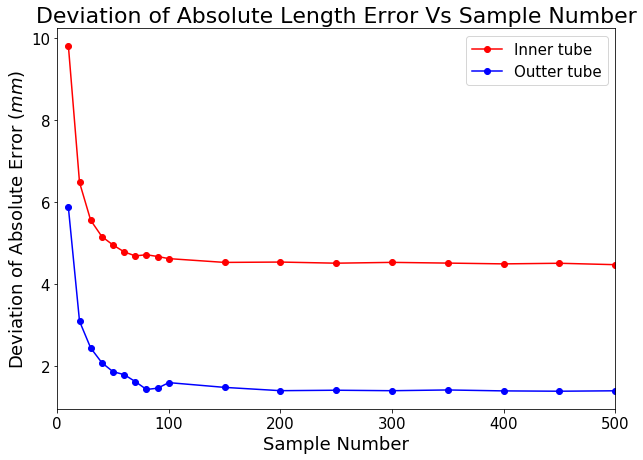

In [218]:
plt.figure(figsize = (10, 7))
#plt.ylim([0, 3])
plt.xlim([0, 500])
plt.plot(x, y_in_std, c = 'r', marker = 'o', label='Inner tube')
plt.plot(x, y_out_std, c = 'b', marker = 'o', label='Outter tube')

plt.title('Deviation of Absolute Length Error Vs Sample Number', fontsize = 22)
plt.ylabel('Deviation of Absolute Error ($mm$)', fontsize=18)
plt.xlabel('Sample Number', fontsize=18)
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15)
plt.legend(fontsize=15)
plt.savefig("error_std_sample_number.pdf", bbox_inches='tight')
plt.show()